## NN Base

### Data Preparation

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import hvplot.xarray
import sys
import tensorflow as tf

%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer



sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray

In [3]:
# Reading Data
dir_name="../data/member_001"
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2=read_xarray(dir_name)

# Creating one singular df
data_read=xr.merge([mld.MLD,mld.MLD_socat,sst.SST,sst.SST_socat,sss.SSS,sss.SSS_socat,xco2])
tmp_data=data_read.to_dataframe().reset_index()

tmp_data=tmp_data.drop(columns=['bnds','TLONG', 'TLAT', 'time_bnds'])

chl_data=chl.Chl.to_dataframe().reset_index()
chl_data_socat=chl.Chl_socat.to_dataframe().reset_index()
pco2_data=pco2.pCO2.to_dataframe().reset_index()
pco2_data_socat=pco2.pCO2_socat.to_dataframe().reset_index()

tmp_data["Chl_socat"]=chl_data_socat["Chl_socat"]
tmp_data["Chl"]=chl_data["Chl"]
tmp_data["pCO2_socat"]=pco2_data_socat["pCO2_socat"]
tmp_data["pCO2"]=pco2_data["pCO2"]

features_socat = ['time', 'xlon', 'ylat','MLD_socat', 'SST_socat', 'SSS_socat','Chl_socat', 'XCO2','pCO2_socat']
features = ['time', 'xlon', 'ylat','MLD','SST','SSS','Chl','XCO2','pCO2']

# create separate dataframe for socat
combined_socat=tmp_data.loc[:,features_socat]
combined=tmp_data.loc[:,features]

# drop rows where pco2 or pco2_socat == NA
combined_socat.dropna(subset = ["pCO2_socat"], inplace=True)
combined_socat= combined_socat[combined_socat['pCO2_socat']!=0]
combined.dropna(subset = ["pCO2"], inplace=True)
combined= combined[combined['pCO2']!=0]



In [4]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

In [5]:
X_socat=combined_socat.iloc[:,3:-1]
X=combined.iloc[:,3:-1]
y=combined.loc[:,'pCO2']
y_socat=combined_socat.loc[:,'pCO2_socat']

In [6]:
X_socat=num_pipeline.fit_transform(X_socat)
X=num_pipeline.fit_transform(X)

In [7]:
def FFN_Model():
    model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(512, activation=tf.nn.relu, kernel_initializer='glorot_normal'),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(1, kernel_initializer='normal')])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
    
    return model

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_socat, y_socat, test_size=0.3, random_state= 42)



In [10]:
model_path = '../models/Simple_NN.h5'

early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 

In [11]:
n_epochs = 60

model = FFN_Model()
history = model.fit(X_train, y_train, epochs=n_epochs, 
                    batch_size=1024, validation_data=(X_test, y_test),callbacks=callbacks)

Epoch 1/60
168/168 [==============================] - 4s 21ms/step - loss: 34373.4258 - mse: 34373.4258 - val_loss: 1711.7689 - val_mse: 1711.7689
Epoch 2/60
168/168 [==============================] - 4s 21ms/step - loss: 1814.5342 - mse: 1814.5342 - val_loss: 1425.2391 - val_mse: 1425.2391
Epoch 3/60
168/168 [==============================] - 4s 24ms/step - loss: 1650.1505 - mse: 1650.1505 - val_loss: 1290.2588 - val_mse: 1290.2588
Epoch 4/60
168/168 [==============================] - 4s 24ms/step - loss: 1584.1538 - mse: 1584.1538 - val_loss: 1268.3434 - val_mse: 1268.3434
Epoch 5/60
168/168 [==============================] - 4s 23ms/step - loss: 1572.9529 - mse: 1572.9529 - val_loss: 1269.3771 - val_mse: 1269.3771
Epoch 6/60
168/168 [==============================] - 4s 25ms/step - loss: 1535.9155 - mse: 1535.9155 - val_loss: 1249.6746 - val_mse: 1249.6746
Epoch 7/60
168/168 [==============================] - 4s 24ms/step - loss: 1532.2179 - mse: 1532.2179 - val_loss: 1241.7681 - va

168/168 [==============================] - 5s 27ms/step - loss: 1414.5304 - mse: 1414.5304 - val_loss: 1220.1362 - val_mse: 1220.1362
Epoch 58/60
168/168 [==============================] - 5s 27ms/step - loss: 1420.6199 - mse: 1420.6199 - val_loss: 1222.4070 - val_mse: 1222.4070
Epoch 59/60
168/168 [==============================] - 4s 26ms/step - loss: 1409.8978 - mse: 1409.8978 - val_loss: 1210.4222 - val_mse: 1210.4222
Epoch 60/60
168/168 [==============================] - 4s 26ms/step - loss: 1413.0670 - mse: 1413.0670 - val_loss: 1206.2867 - val_mse: 1206.2867


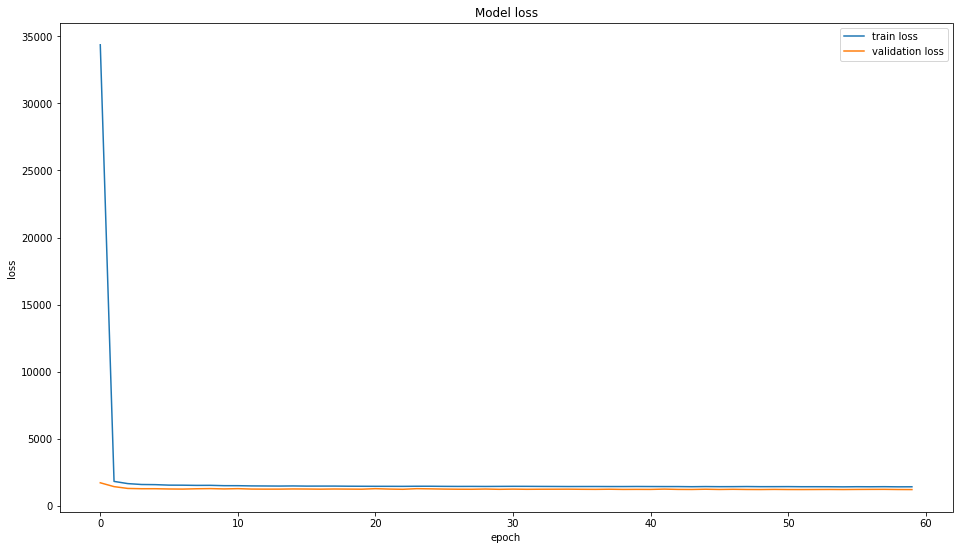

In [13]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'validation loss'])
plt.show() 

### Prediction On Full

In [15]:
y_hat=model.predict(X,verbose=1)

540328/540328 [==============================] - 457s 845us/step


In [17]:
final_test_rmse=np.sqrt(mean_squared_error(y, y_hat,squared=True))


In [18]:
final_test_rmse

39.49373641112186